In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import itertools

from environment import TrafficModel, Car
from util.network import create_braess_network, create_double_braess_network, create_cars

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import trange

## Find optimal capacity for unrestricted vs. restricted

### Demand is 0-3

100%|██████████| 28/28 [00:43<00:00,  1.54s/it]


Best improvement found with capacity: 13


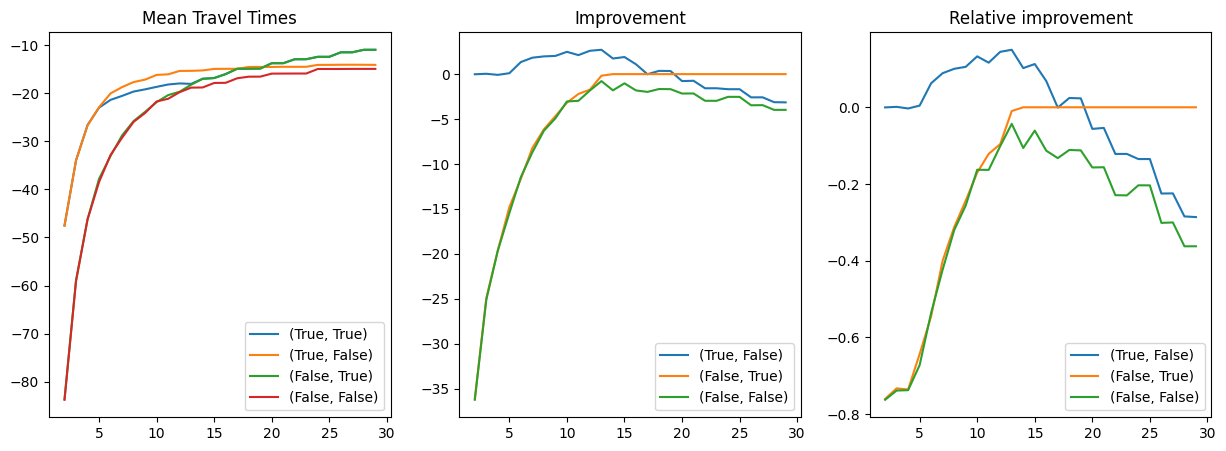

In [23]:
number_of_steps = 1000
car_counts = {(0, 3): 30}

mean_travel_times = []
for capacity in trange(2, 30):
    mean_travel_times.append({})
    for allowed_edges in itertools.product([True, False], repeat=2):
        network = create_double_braess_network(capacity=capacity)
        model = TrafficModel(network, create_cars(network, car_counts=car_counts))
        model.set_edge_restriction((0, 2), allowed=allowed_edges[0])
        model.set_edge_restriction((1, 2), allowed=allowed_edges[1])
        step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

        mean_travel_times[-1][allowed_edges] = (-car_stats["travel_time"]).mean()

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

mean_travel_times = pd.DataFrame(mean_travel_times)

ax1.plot(range(2,30), mean_travel_times)
ax1.legend(mean_travel_times.columns)
ax1.set_title('Mean Travel Times')

improvement = mean_travel_times.drop([(True, True)], axis=1).sub(mean_travel_times[(True, True)], axis=0)
ax2.plot(range(2,30), improvement)
ax2.legend(improvement.columns)
ax2.set_title('Improvement')

relative_improvement = improvement.div(mean_travel_times[(True, True)].abs(), axis=0)
ax3.plot(range(2,30), relative_improvement)
ax3.legend(relative_improvement.columns)
ax3.set_title('Relative improvement')

print(f'Best improvement found with capacity: {np.argmax(improvement.max(axis=1)) + 2}')

### Demand is A-B

100%|██████████| 28/28 [00:48<00:00,  1.75s/it]


Best improvement found with capacity: 4


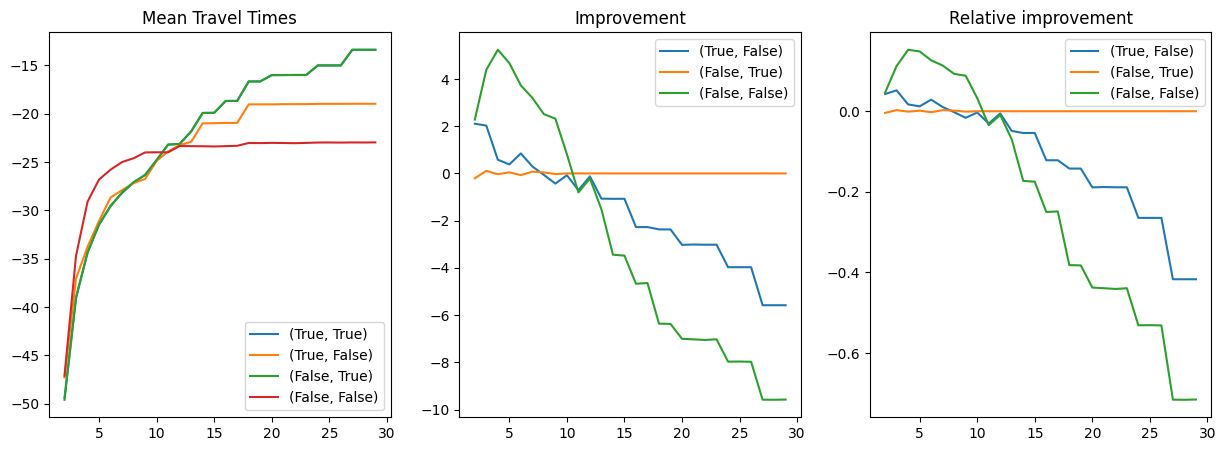

In [24]:
number_of_steps = 1000
car_counts = {('A', 'B'): 30}

mean_travel_times = []
for capacity in trange(2, 30):
    mean_travel_times.append({})
    for allowed_edges in itertools.product([True, False], repeat=2):
        network = create_double_braess_network(capacity=capacity)
        model = TrafficModel(network, create_cars(network, car_counts=car_counts))
        model.set_edge_restriction((0, 2), allowed=allowed_edges[0])
        model.set_edge_restriction((1, 2), allowed=allowed_edges[1])
        step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

        mean_travel_times[-1][allowed_edges] = (-car_stats["travel_time"]).mean()

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

mean_travel_times = pd.DataFrame(mean_travel_times)

ax1.plot(range(2,30), mean_travel_times)
ax1.legend(mean_travel_times.columns)
ax1.set_title('Mean Travel Times')

improvement = mean_travel_times.drop([(True, True)], axis=1).sub(mean_travel_times[(True, True)], axis=0)
ax2.plot(range(2,30), improvement)
ax2.legend(improvement.columns)
ax2.set_title('Improvement')

relative_improvement = improvement.div(mean_travel_times[(True, True)].abs(), axis=0)
ax3.plot(range(2,30), relative_improvement)
ax3.legend(relative_improvement.columns)
ax3.set_title('Relative improvement')

print(f'Best improvement found with capacity: {np.argmax(improvement.max(axis=1)) + 2}')

## Test scenarios individually

In [26]:
capacity = 4

In [27]:
def plot_results(car_stats, *, title):
    stats = car_stats.set_index('step')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    pd.DataFrame({route: stats['route'] == route for route in stats['route'].unique()}).expanding().mean().plot(ax=ax1)
    ax1.legend(stats['route'].unique())
    ax1.set_title('Fraction of cars per route')

    pd.DataFrame({'Travel time': stats['travel_time'], 'Total cost': stats['total_cost']}).expanding().mean().plot(ax=ax2)
    ax2.set_title('Social welfare')

    fig.suptitle(title)

### Unrestricted

In [30]:
network = create_double_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

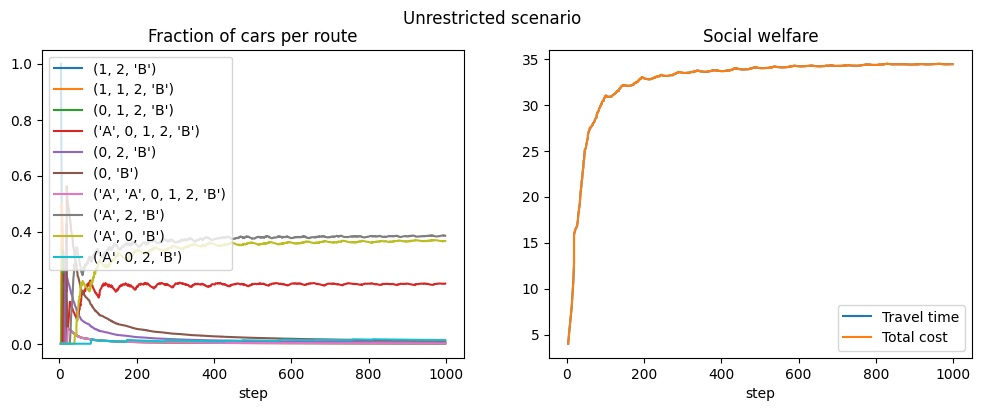

In [31]:
plot_results(car_stats, title='Unrestricted scenario')

### Restricted

In [36]:
network = create_double_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
model.set_edge_restriction((0, 2), False)
model.set_edge_restriction((1, 2), False)
step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

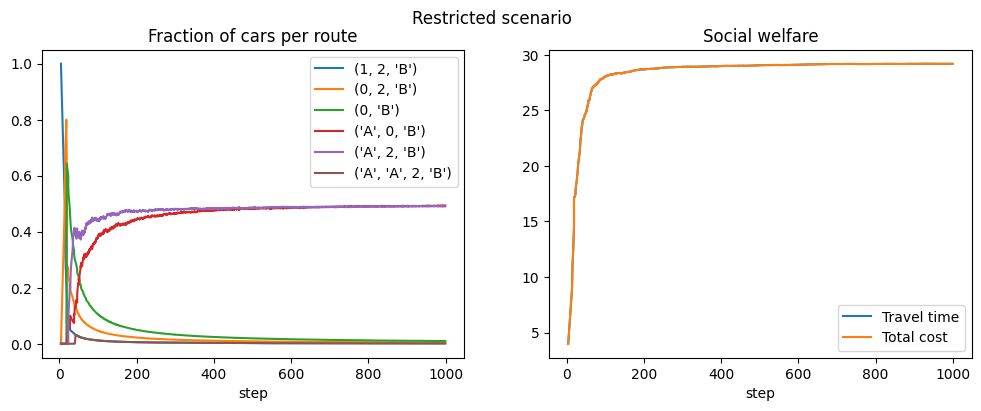

In [37]:
plot_results(car_stats, title='Restricted scenario')

### Tolling

Mean travel time with tolling: -33.3718820861678
Mean total cost with tolling: -44.05719507447485


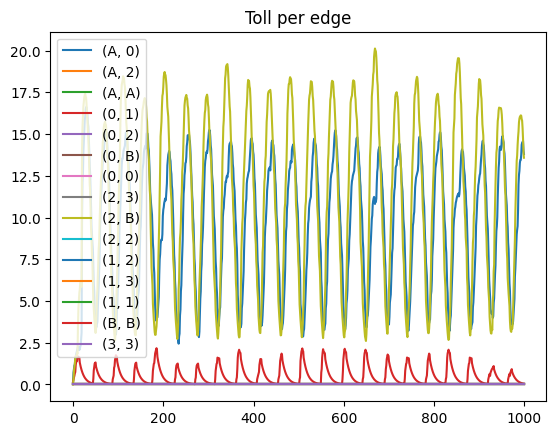

In [38]:
from util.analysis import plot_toll_per_edge, plot_cars_per_edge

network = create_double_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts), tolls=True, beta=1, R=0.1)
step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Mean travel time with tolling: {(-car_stats["travel_time"]).mean()}')
print(f'Mean total cost with tolling: {(-car_stats["total_cost"]).mean()}')

plot_toll_per_edge(step_stats)

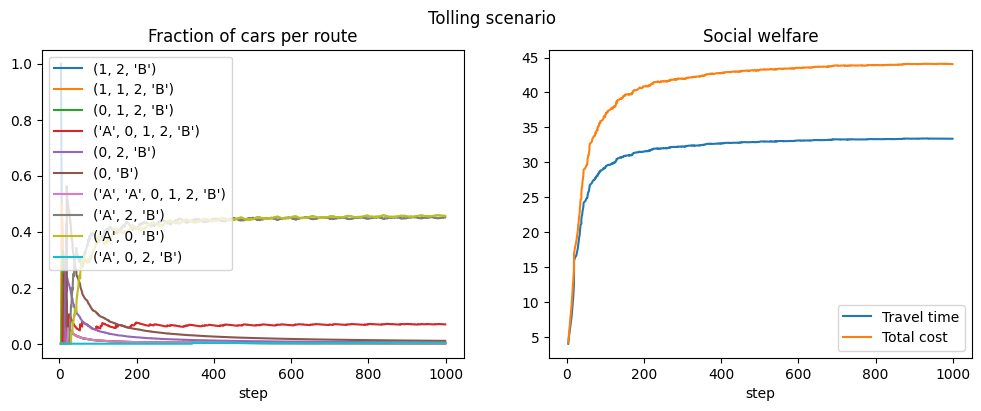

In [39]:
plot_results(car_stats, title='Tolling scenario')

## Compare unrestricted vs. restricted vs. tolling for optimal capacity

In [4]:
capacity = 4

In [42]:
# Unrestricted
network = create_double_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
_, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Unrestricted mean travel time: {(-car_stats_unrestricted["travel_time"]).mean()}')

# Restricted
network = create_double_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
model.set_edge_restriction((0, 2), False)
model.set_edge_restriction((1, 2), False)
_, car_stats_restricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Restricted mean travel time: {(-car_stats_restricted["travel_time"]).mean()}')

# Tolling
network = create_double_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts), tolls=True, beta=1, R=0.2)
_, car_stats_tolling = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Mean travel time with tolling: {(-car_stats_tolling["travel_time"]).mean()}')
print(f'Mean total cost with tolling: {(-car_stats_tolling["total_cost"]).mean()}')

Unrestricted mean travel time: -34.25522041763341
Restricted mean travel time: -29.28586609989373
Mean travel time with tolling: -33.34537246049661
Mean total cost with tolling: -44.91495101369045


Text(0.5, 0.98, "Braess' Paradox")

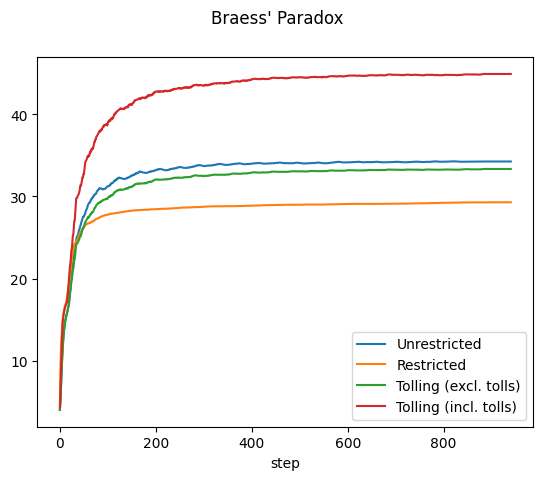

In [43]:
fig, ax = plt.subplots(1, 1)

pd.DataFrame({
    'Unrestricted': car_stats_unrestricted['travel_time'], 
    'Restricted': car_stats_restricted['travel_time'], 
    'Tolling (excl. tolls)': car_stats_tolling['travel_time'], 
    'Tolling (incl. tolls)': car_stats_tolling['total_cost']}).expanding().mean().plot(ax=ax, xlabel='step')

fig.suptitle("Braess' Paradox")

## Use different values for `value_of_money` and check for fairness

In [45]:
def change_value_of_money(cars, possible_values, *, seed=42):
    rng = np.random.default_rng(seed)

    for car in cars.values():
        car.value_of_money = rng.choice(possible_values)

In [54]:
number_of_steps = 1000

network = create_double_braess_network(capacity=4)
cars = create_cars(network, car_counts={('A', 'B'): 30})

# Assign different value_of_money to cars
change_value_of_money(cars, [0.0, 0.5, 1.0, 2.0, 5.0])

# Run unrestricted
model = TrafficModel(network, cars)
_, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Unrestricted mean travel time: {(-car_stats_unrestricted["travel_time"]).mean()}')

Unrestricted mean travel time: -34.48009367681499


In [56]:
number_of_steps = 1000

network = create_double_braess_network(capacity=4)
cars = create_cars(network, car_counts={('A', 'B'): 30})

# Assign different value_of_money to cars
change_value_of_money(cars, [0.0, 0.5, 1.0, 2.0, 5.0])

# Run restricted
model = TrafficModel(network, cars)
model.set_edge_restriction((0, 2), False)
model.set_edge_restriction((1, 2), False)
_, car_stats_restricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Restricted mean travel time: {(-car_stats_restricted["travel_time"]).mean()}')

Restricted mean travel time: -29.053740779768177


In [60]:
number_of_steps = 1000

network = create_double_braess_network(capacity=4)
cars = create_cars(network, car_counts={('A', 'B'): 30})

# Assign different value_of_money to cars
change_value_of_money(cars, [0.0, 0.5, 1.0, 2.0, 5.0])

# Run tolling
model = TrafficModel(network, cars, tolls=True, beta=1, R=0.2)
_, car_stats_tolling = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Mean travel time with tolling: {(-car_stats_tolling["travel_time"]).mean()}')
print(f'Mean total cost with tolling: {(-car_stats_tolling["total_cost"]).mean()}')

Mean travel time with tolling: -32.87262569832402
Mean total cost with tolling: -52.67946592120323


In [61]:
u = car_stats_unrestricted.groupby('value_of_money')['travel_time'].mean()
r = car_stats_restricted.groupby('value_of_money')['travel_time'].mean()
t = car_stats_tolling.groupby('value_of_money')['travel_time'].mean()

travel_times = pd.concat([u, r, t], keys=['unrestricted', 'restricted', 'tolling'], axis=1)

Text(0.5, 1.0, 'Travel times grouped by value of money')

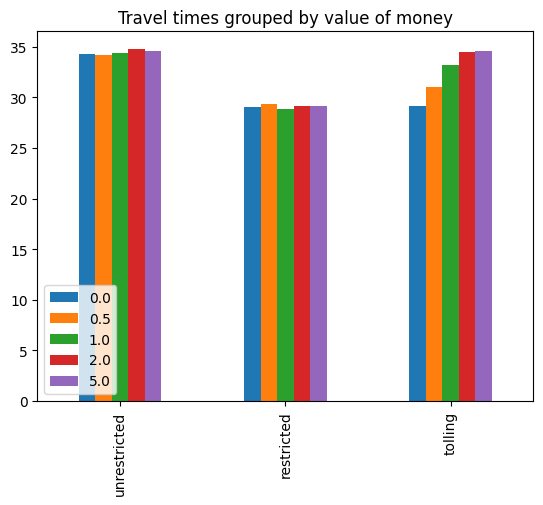

In [62]:
ax = travel_times.transpose().plot(kind='bar')
ax.legend(loc='lower left')
ax.set_title('Travel times grouped by value of money')

In [63]:
travel_times.std()

unrestricted    0.238562
restricted      0.173300
tolling         2.329089
dtype: float64

## Change demand in phases to test dynamic restrictions

In [3]:
phases = [
    ({(0, 3): 30}, 1_000),
    ({('A', 'B'): 30}, 1_000),
    ({(0, 3): 30}, 1_000)
]

In [8]:
capacity = 13

network = create_double_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=phases[0][0]), tolls=True, beta=1, R=0.2)
_, car_stats_unrestricted = model.run_sequentially_with_phases(phases, show_progress=False)
print(f'Unrestricted mean travel time: {(-car_stats_unrestricted["travel_time"]).mean()}')

Running demand {(0, 3): 30} for 1000 steps...
Running demand {('A', 'B'): 30} for 1000 steps...
Running demand {(0, 3): 30} for 1000 steps...
Unrestricted mean travel time: -16.764387144992526


<Axes: xlabel='step'>

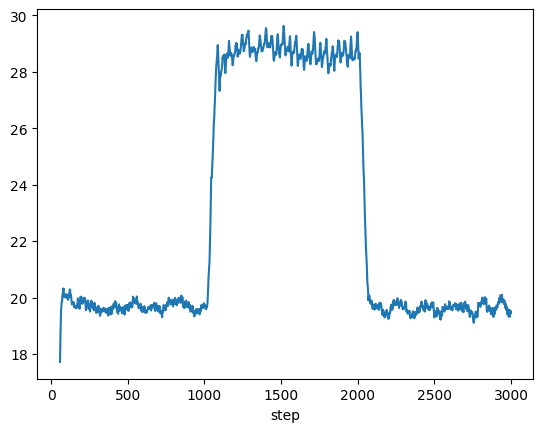

In [18]:
car_stats_unrestricted.groupby("step")["total_cost"].mean().rolling(50).mean().plot()